In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

from fredapi import Fred

fred_key = 'ea41c383b02a6694672a29dd7434e0b9'

In [2]:
fred = Fred(api_key=fred_key)

In [3]:
sp_search = fred.search('S&P', order_by='popularity')

In [4]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2023-03-12   2023-03-12   
CSUSHPINSA          CSUSHPINSA     2023-03-12   2023-03-12   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2023-03-12   2023-03-12   
SP500                    SP500     2023-03-12   2023-03-12   
CSUSHPISA            CSUSHPISA     2023-03-12   2023-03-12   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA        S&P/Case-Shiller U.S. National Home Price Index   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   
SP500                                                     S&P 500   
CSUSHPISA         S&P/Case-Shiller U.S. National Home Price Index   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2023-03-09  Daily, Close   
CSUSHPINSA            1987-01-01      2022-12-01       Monthly   
BAMLH0A0HYM2EY        1996-12-31      2023-03-09  Daily, Close   
SP500                 2013-03-11      2023-03-10  Daily, Close   
CSUSHPISA             1987-01-01      2022-12-01       Monthly   

               frequency_short               units         units_short  \
series id                                                                
BAMLH0A0HYM2                 D             Percent                   %   
CSUSHPINSA                   M  Index Jan 2000=100  Index Jan 2000=100   
BAMLH0A0HYM2EY               D             Percent                   %   
SP500                        D               Index               Index   
CSUSHPISA                    M  Index Jan 2000=100  Index Jan 2000=100   

                    seasonal_adjustment seasonal_adjustment_short  \
series id                                                           
BAMLH0A0HYM2    Not Seasonally Adjusted                       NSA   
CSUSHPINSA      Not Seasonally Adjusted                       NSA   
BAMLH0A0HYM2EY  Not Seasonally Adjusted                       NSA   
SP500           Not Seasonally Adjusted                       NSA   
CSUSHPISA           Seasonally Adjusted                        SA   

                             last_updated popularity  \
series id                                              
BAMLH0A0HYM2    2023-03-10 09:18:10-06:00         94   
CSUSHPINSA      2023-02-28 08:02:02-06:00         91   
BAMLH0A0HYM2EY  2023-03-10 09:18:14-06:00         84   
SP500           2023-03-10 19:10:59-06:00         83   
CSUSHPISA       2023-02-28 08:02:04-06:00         82   

                                                            notes  
series id                                                          
BAMLH0A0HYM2    The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA      For more information regarding the index, plea...  
BAMLH0A0HYM2EY  This data represents the effective yield of th...  
SP500           The observations for the S&P 500 represent the...  
CSUSHPISA       For more information regarding the index, plea...

### 3. Pull Raw Data & Plot

In [5]:
sp500 = fred.get_series(series_id='SP500')
sp500

2013-03-11    1556.22
2013-03-12    1552.48
2013-03-13    1554.52
2013-03-14    1563.23
2013-03-15    1560.70
               ...   
2023-03-06    4048.42
2023-03-07    3986.37
2023-03-08    3992.01
2023-03-09    3918.32
2023-03-10    3861.59
Length: 2610, dtype: float64

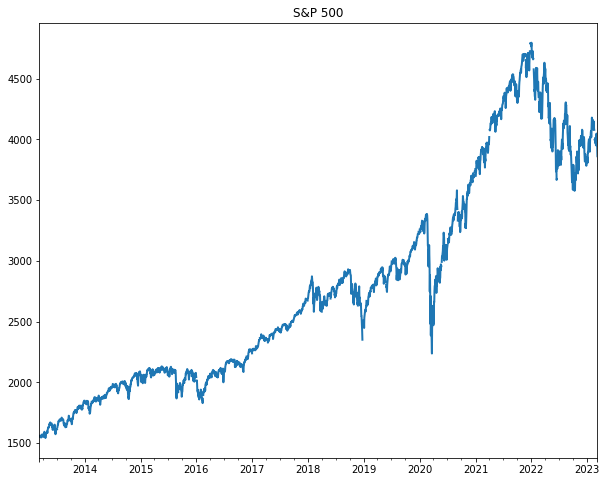

In [6]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 8), title='S&P 500', lw=2)
plt.show()

### Pull and Join Multiple Data Series

In [7]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [8]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [9]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [10]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [11]:
# Plot States Unemployment Rate
px.line(uemp_states)

### Pull April 2020 Unemployment Rate Per State

<AxesSubplot: title={'center': 'Unemployment Rate by State, May 2020'}>

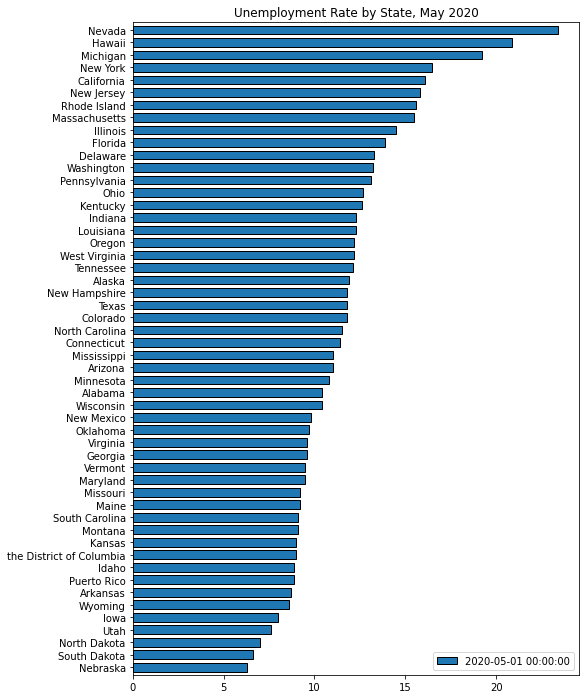

In [12]:
uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')

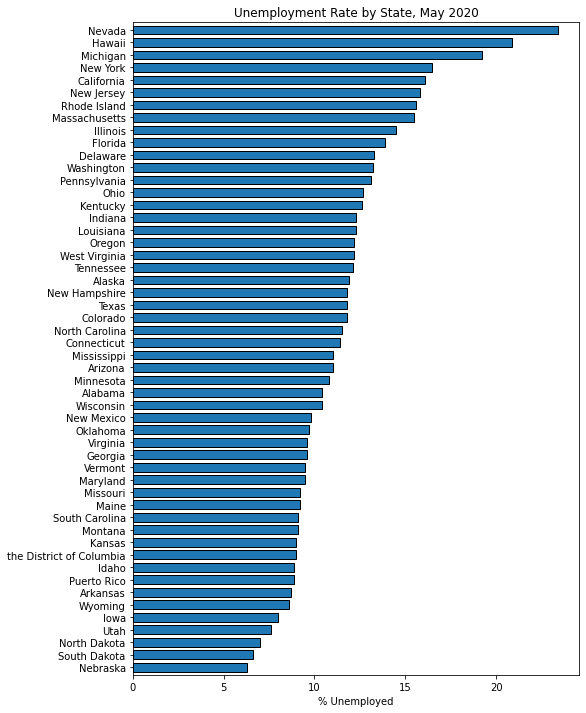

In [13]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

### Pull Participation Rate

In [14]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [15]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

### Plot Unemployment vs Participation for each state!

In [16]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

In [23]:
color_pal = ["#6495ED", "#F08080", "#FFA07A", "#90EE90", "#FFB6C1", "#FFE4C4"]

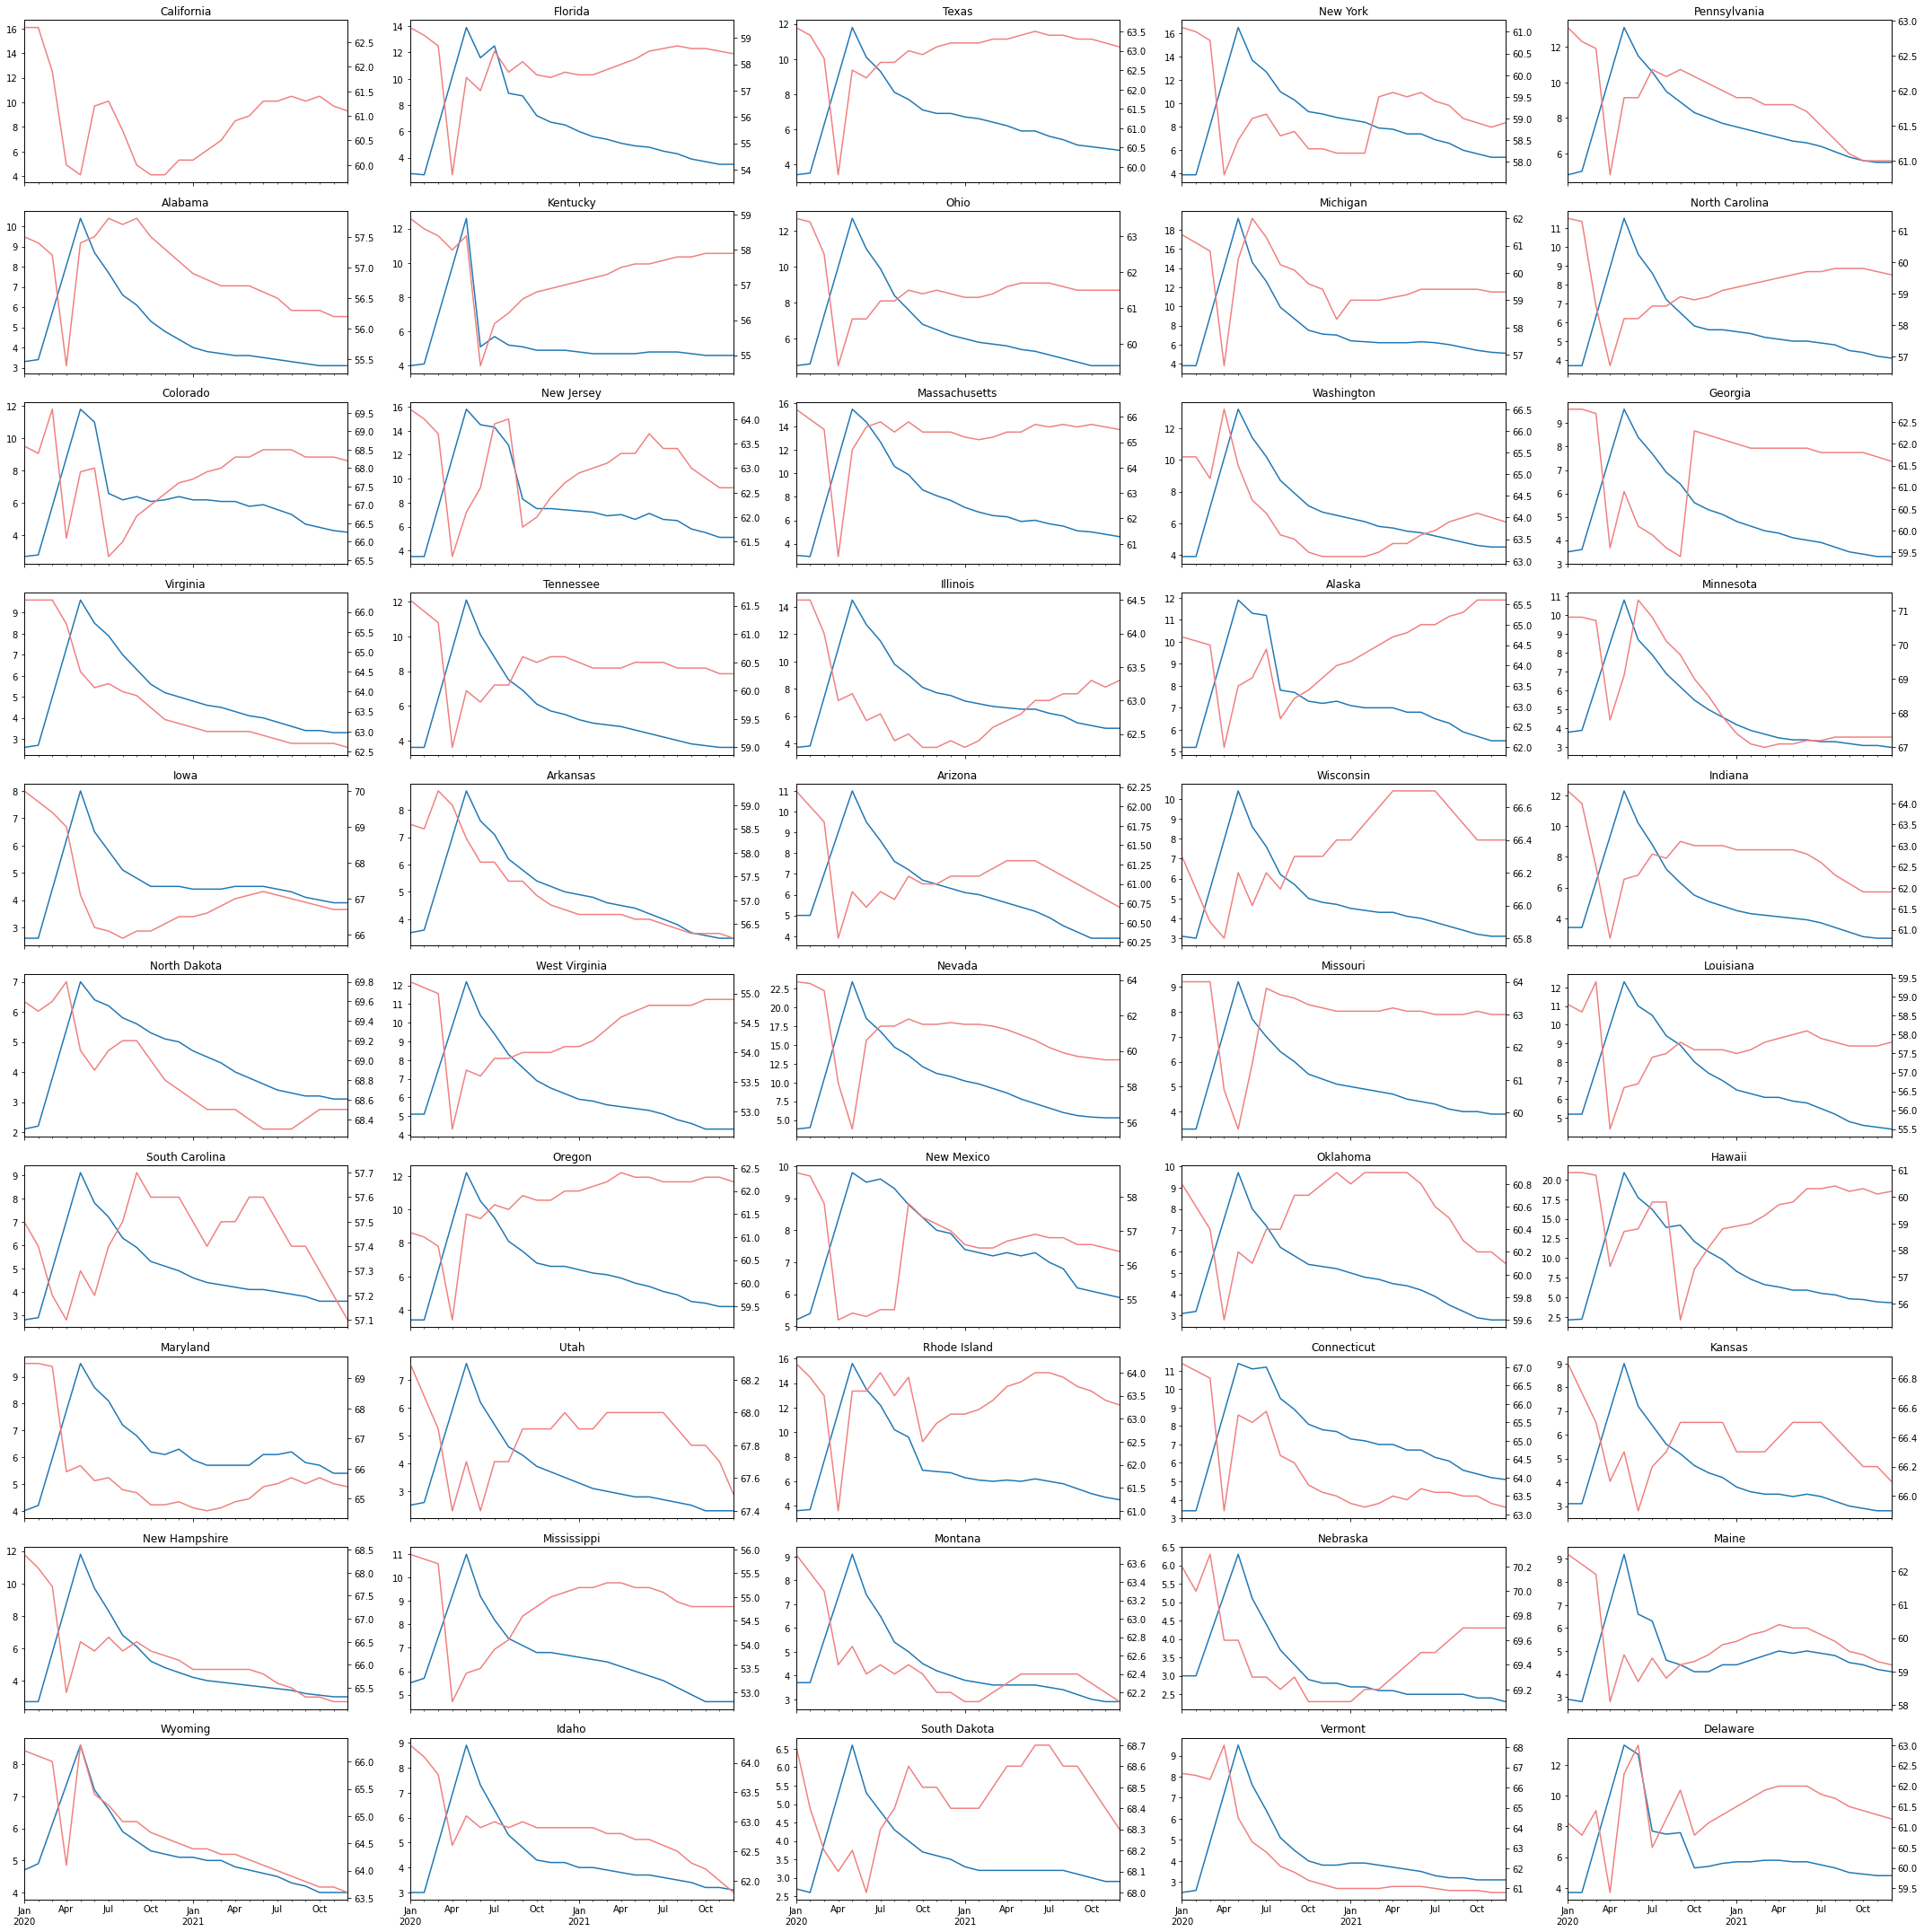

In [25]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

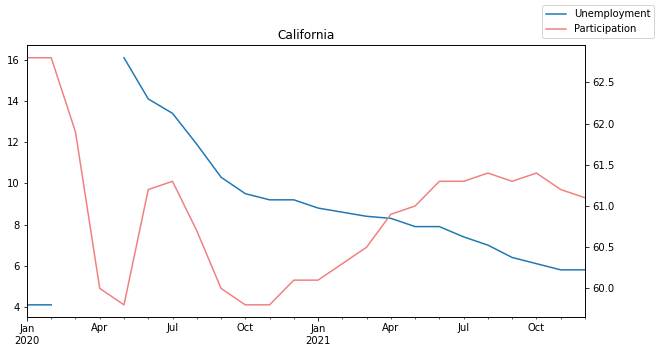

In [24]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()